# Introduction

This tutorial uses data from [__AirBnB's 2015 recruiting competition on Kaggle.com__](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) to demo the following tools:

- [__`Pandas`__](http://pandas.pydata.org), a `Python` tool for creating and manipulating SQL-like tabular data through __data frames__, inspired by `R`'s `data.frame` and `data.table` packages;

- [__`PySpark DataFrame`__ & __`PySpark SQL`__](http://spark.apache.org/docs/latest/sql-programming-guide.html), data-frame and SQL features shipped as part of large-scale distributed in-memory computing solution [__`Apache Spark`__](http://spark.apache.org) and well-integrated with `Pandas`.


To enable faster data import and demonstrating SQL-related capabilities, the `.CSV` data files provided on Kaggle have been uploaded to a `PostgreSQL` database hosted on Amazon Web Services (AWS) Relational Database Service (RDS) under Chicago Booth Analytics's account.

We will also showcase 2 visualization packages that are particularly well-integrated with data frames, namely __`GGplot`__ and __`Seaborn`__, which are higher-level wrappers around `Python`'s default visualization package `MatPlotLib`, although visualization is not the focus of this tutorial and will be covered more extensively in other tutorials.

# _\*\*\* Note on Technical Dependencies \*\*\*_

This tutorial requires the following software, assuming you are running on your personal computer:

- __`Anaconda Python` v2.7__ distribution;
    - You may follow the [__`Anaconda Python` installation guide__ on the Booth Analytics wiki]();
<br><br>

- __`SQLalchemy`__ Python package _(should already be included in `Anaconda Python` distribution)_;
<br><br>

- __`psycopy2`__ Python package, a driver for interacting with `PostgreSQL` though Python;
    - if your operating system is __Mac__, this should already be included in `Anaconda Python` distribution;
    - if your operating system is __Windows__, you can download and install the package from [__here__](http://www.lfd.uci.edu/~gohlke/pythonlibs/#psycopg); do select the correct version for `Python` v2.7 and for your processor (32-bit / 64-bit); <br><br>

- __`Apache Spark` v1.5.2 or later__, pre-built for Hadoop 2.6 or later _(go to [`Spark` download page](http://spark.apache.org/downloads.html) and you'll see something like that)_, downloaded and unpacked into a folder on your computer (_e.g._, `/Applications/spark-1.5.2` in my case);
    - Please do check out [__`Spark` installation guide__ on the Booth Analytics wiki](https://github.com/ChicagoBoothAnalytics/site/wiki/Apache-Spark-Installation) for important notes on setting environment variables;
<br><br>
    
- __`FindSpark`__ Python package, a useful utility to help load up the `PySpark` API in `Python`;
    - Install it simply by running command __`pip install --upgrade FindSpark`__ in your command-line terminal.
<br><br>

- __`GGplot`__ Python package for visualization;
    - Install by running command __`pip install --upgrade GGplot`__ in your command-line terminal;
<br><br>

- __`Seaborn`__ Python package for visualization;
    - Install by running command __`conda install Seaborn`__ in your command-line terminal.

# Import Python modules

In [1]:
from __future__ import print_function
import datetime
import numpy
import os
import pandas
from pprint import pprint
import sys

In [2]:
# enable in-line plotting
%matplotlib inline

# import visualization packages
import matplotlib
import ggplot
import seaborn

C:\Programs\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# hack for live printing in iPython Notebook, adapted from:
# http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
        
oldsysstdout = sys.stdout        
sys.stdout = flushfile(sys.stdout)

# Set _CONSTANTS_

In [4]:
# detect if running on Amazon Web Services (AWS) Elastic MapReduce (EMR)
# NOTE: the following line's method is specific to how ChicagoBoothML sets up AWS EMR clusters;
# in your own case, if you use AWS EMR, please come up with your own way of telling
AWS_EMR_MODE = os.path.expanduser('~').startswith('/mnt')

# set Apache Spark-related constants, depending on AWS_EMR_MODE
if AWS_EMR_MODE:                               # if running Spark on AWS Elastic MapReduce (EMR) YARN cluster
    SPARK_MODE = 'yarn-client'
    SPARK_HOME = '/usr/lib/spark'              # default Spark installation folder on AWS EMR master node
else:                                          # if running Spark on single machine
    SPARK_MODE = 'local'
    SPARK_HOME = 'C:/Programs/spark-1.5.2'   # Spark installation folder on my machine; *** CHANGE TO SUIT YOURS ***
                                               # e.g., '/Applications/spark-1.5.2', 'C:/Programs/spark-1.5.2'

# Kaggle AirBnB database specs
DB_ENGINE = 'postgresql'                                                 # this is a PostgreSQL database on AWS RDS
DB_HOST_URL = 'kaggle-airbnb.clloyfrn47sj.us-west-1.rds.amazonaws.com'   # database's host server URL
DB_PORT = 5432                                                           # default port for PostgreSQL
DB_NAME = 'Kaggle_AirBnB'                                                # database's name
DB_USER_NAME = 'BoothAnalytics'                                          # database's master username
DB_PASSWORD = 'password'                                                 # database's master password
DB_ACCESS_URL = '%s://%s:%i/%s?user=%s&password=%s' \
    % (DB_ENGINE, DB_HOST_URL, DB_PORT, DB_NAME, DB_USER_NAME, DB_PASSWORD)
JDBC_DB_ACCESS_URL = 'jdbc:%s' % DB_ACCESS_URL 

# local .CSV data files
LOCAL_DATA_FOLDER_PATH = '../data'
USERS_DATA_FILE_NAME = 'train_users_2.csv'
COUNTRIES_DATA_FILE_NAME = 'countries.csv'
AGE_GENDER_DESTINATION_STATS_FILE_NAME = 'age_gender_bkts.csv'
USERS_DATA_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        USERS_DATA_FILE_NAME)\
    .replace('\\', '/')
COUNTRIES_DATA_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        COUNTRIES_DATA_FILE_NAME)\
    .replace('\\', '/')
AGE_GENDER_DESTINATION_STATS_FILE_PATH = \
    os.path.join(
        LOCAL_DATA_FOLDER_PATH,
        AGE_GENDER_DESTINATION_STATS_FILE_NAME)\
    .replace('\\', '/')

# GitHub repo raw path
# GITHUB_REPO_RAW_PATH = 'https://raw.githubusercontent.com/ChicagoBoothAnalytics/RelationalData/master'
# SQL_JDBC_DRIVERS_FOLDER_NAME = 'SQL-JDBC-Drivers'
# POSTGRESQL_JDBC_DRIVER_FILE_NAME = 'PostgreSQL-JDBC42-9.4.1207.jar'
# POSTGRESQL_JDBC_DRIVER_URL = \
#     os.path.join(
#         GITHUB_REPO_RAW_PATH,
#         SQL_JDBC_DRIVERS_FOLDER_NAME,
#         POSTGRESQL_JDBC_DRIVER_FILE_NAME)\
#     .replace('\\', '/')

# number of examples to show from a data set   
NB_EXAMPLES_TO_SHOW = 30

# ISO days of week
ISO_DAYS_OF_WEEK = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

# Set up `SparkContext` & `SQLContext`

In [5]:
if 'pyspark' not in vars():
    
    # set / clean up environment variables for Spark
    os.environ['SPARK_HOME'] = SPARK_HOME
    print("Removing any existing 'SPARK_CLASSPATH' environment variable: ", end='')
    spark_classpath = os.environ.pop('SPARK_CLASSPATH', None)
    if spark_classpath:
        print("'%s', done!\n" % spark_classpath)
    else:
        print('done!\n')
    
    # import FindSpark to enable importing of PySpark
    import findspark
    findspark.init()
    
    # import PySpark and set up SparkContext & HiveContext
    import pyspark
    
    sc = pyspark.SparkContext(
        conf=pyspark.SparkConf()
            .setMaster(SPARK_MODE)
            .setAppName('KaggleAirBnB'))
    sc_confs_df = \
        pandas.DataFrame(
            data=sc._conf.getAll(),
            columns=['key', 'value'])\
        .sort_values(by='key')
    
    sqlc = pyspark.sql.SQLContext(sc)
    
print('SparkContext: %s\n' % str(sc))
print('SQLContext: %s\n' % str(sqlc))
print('Detailed (Non-Default) SparkContext Configurations:')
sc_confs_df

Removing any existing 'SPARK_CLASSPATH' environment variable: 'C:/Programs/PostgreSQL/9.4/postgresql-9.4-1205.jdbc42.jar', done!

SparkContext: <pyspark.context.SparkContext object at 0x000000001D1DB780>

SQLContext: <pyspark.sql.context.SQLContext object at 0x000000001D29E5C0>

Detailed (Non-Default) SparkContext Configurations:


,key,value
9,spark.app.name,KaggleAirBnB
3,spark.driver.extraClassPath,C:/Repos/MBALearnsToCode/RelationalData/SQL-JD...
7,spark.driver.maxResultSize,3g
2,spark.driver.memory,6g
8,spark.executor.extraClassPath,C:/Repos/MBALearnsToCode/RelationalData/SQL-JD...
1,spark.executor.memory,2g
0,spark.master,local
4,spark.rdd.compress,True
5,spark.serializer.objectStreamReset,100
6,spark.submit.deployMode,client


# Import additional modules / classes / functions from `PySpark`

In [6]:
from pyspark.files import SparkFiles

# Download & import __`PySpark_CSV.py`__ utility

In [7]:
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py

if AWS_EMR_MODE:
    sc.addPyFile('pyspark_csv.py')

from pyspark_csv import csvToDataFrame

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5493  100  5493    0     0   7324      0 --:--:-- --:--:-- --:--:--  7324


# Read Kaggle AirBnB Data

## __`users`__ table

### ___`Pandas`___

In [8]:
print("Reading 'users[_train]' database table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

users_df = \
    pandas.read_sql_table(
        table_name='users_train',   # Name of SQL table in database
        con=DB_ACCESS_URL,          # SQLAlchemy connectable (or database string URI)
        schema=None,                # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,             # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,          # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,           # List of column names to parse as dates
        columns=None,               # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'users' table (Pandas DataFrame):\n")
users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_df.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'users[_train]' database table into Pandas DataFrame... done after 0:00:19.926000

'users' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null object
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null objec

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


We can alternatively read from a local `.CSV` file:

In [9]:
print("Reading '%s' file into Pandas DataFrame... " % USERS_DATA_FILE_NAME, end='')
tic = datetime.datetime.now()

users_df_from_csv = pandas.read_csv(USERS_DATA_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'users' table (Pandas DataFrame):\n")
users_df_from_csv.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_df_from_csv.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'train_users_2.csv' file into Pandas DataFrame... done after 0:00:00.724000

'users' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination  

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


### ___`PySpark SQL`___

In [10]:
try:
    
    print("Reading 'users[_train]' database table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    users_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='users_train')\
        .cache()    
    users_ddf.registerTempTable('users')

    print('done!\n')

    print("'users' table (PySpark SQL Distributed DataFrame):\n")
    users_ddf.printSchema()

    print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
    users_ddf.show(NB_EXAMPLES_TO_SHOW)

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    users_spark_sql_read_success = True
    
except:
    
    users_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'users[_train]' database table into PySpark SQL Distributed DataFrame... done!

'users' table (PySpark SQL Distributed DataFrame):

root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)


Showing first 30 rows:
+----------+--------------------+----------------------+------------------+---------+----+-----------

We can also read from a local `.CSV` file:

In [11]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = USERS_DATA_FILE_NAME
    os.system('hadoop fs -put %s %s' % (USERS_DATA_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = USERS_DATA_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % USERS_DATA_FILE_NAME, end='')

users_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'users' table (PySpark SQL Distributed DataFrame):\n")
users_ddf_from_csv.printSchema()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
users_ddf_from_csv.show(NB_EXAMPLES_TO_SHOW)

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not users_spark_sql_read_success:
    users_ddf = users_df_from_csv
    users_ddf.cache()
    users_ddf.registerTempTable('users')

Reading 'train_users_2.csv' into PySpark SQL Distributed DataFrame... 

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1.0 (TID 1, localhost): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:109)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:153)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:622)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:442)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1699)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1824)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:109)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:153)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.write(BufferedOutputStream.java:126)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.io.FilterOutputStream.write(FilterOutputStream.java:97)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:622)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:442)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:452)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1699)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)


## __`countries`__ table

### ___`Pandas`___

In [12]:
print("Reading 'countries' table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

countries_df = \
    pandas.read_sql_table(
        table_name='countries',   # Name of SQL table in database
        con=DB_ACCESS_URL,        # SQLAlchemy connectable (or database string URI)
        schema=None,              # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,           # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,        # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,         # List of column names to parse as dates
        columns=None,             # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'countries' table (Pandas DataFrame):\n")
countries_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)
countries_df

Reading 'countries' table into Pandas DataFrame... done after 0:00:02.632000

'countries' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.7 KB


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


Alternative reading from local `.CSV` file:

In [13]:
print("Reading '%s' file into Pandas DataFrame... " % COUNTRIES_DATA_FILE_NAME, end='')
tic = datetime.datetime.now()

countries_df_from_csv = pandas.read_csv(COUNTRIES_DATA_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'countries' table (Pandas DataFrame):\n")
countries_df_from_csv.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)
countries_df_from_csv

Reading 'countries.csv' file into Pandas DataFrame... done after 0:00:00.001000

'countries' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.3 KB


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


### ___`PySpark SQL`___

In [14]:
try:
    
    print("Reading 'countries' table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    countries_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='countries')\
        .cache()
    countries_ddf.registerTempTable('countries')

    print('done!\n')

    print("'coutnries' table (Spark SQL Distributed Data Frame):\n")
    countries_ddf.printSchema()
    countries_ddf.show()

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    countries_spark_sql_read_success = True
    
except:
    
    countries_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'countries' table into PySpark SQL Distributed DataFrame... done!

'coutnries' table (Spark SQL Distributed Data Frame):

root
 |-- country_destination: string (nullable = true)
 |-- lat_destination: double (nullable = true)
 |-- lng_destination: double (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- destination_km2: double (nullable = true)
 |-- destination_language: string (nullable = true)
 |-- language_levenshtein_distance: double (nullable = true)

+-------------------+---------------+---------------+-----------+---------------+--------------------+-----------------------------+
|country_destination|lat_destination|lng_destination|distance_km|destination_km2|destination_language|language_levenshtein_distance|
+-------------------+---------------+---------------+-----------+---------------+--------------------+-----------------------------+
|                 AU|     -26.853388|      133.27516|  15297.744|      7741220.0|                 eng|               

In [15]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = COUNTRIES_DATA_FILE_NAME
    os.system('hadoop fs -put %s %s' % (COUNTRIES_DATA_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = COUNTRIES_DATA_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % COUNTRIES_DATA_FILE_NAME, end='')

countries_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'countries' table (PySpark SQL Distributed DataFrame):\n")
countries_ddf_from_csv.printSchema()
countries_ddf_from_csv.show()

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not countries_spark_sql_read_success:
    countries_ddf = countries_ddf_from_csv
    countries_ddf.cache()
    countries_ddf.registerTempTable('countries')

Reading 'countries.csv' into PySpark SQL Distributed DataFrame... done!

'countries' table (PySpark SQL Distributed DataFrame):

root
 |-- country_destination: string (nullable = true)
 |-- lat_destination: double (nullable = true)
 |-- lng_destination: double (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- destination_km2: integer (nullable = true)
 |-- destination_language : string (nullable = true)
 |-- language_levenshtein_distance: double (nullable = true)

+-------------------+---------------+---------------+-----------+---------------+---------------------+-----------------------------+
|country_destination|lat_destination|lng_destination|distance_km|destination_km2|destination_language |language_levenshtein_distance|
+-------------------+---------------+---------------+-----------+---------------+---------------------+-----------------------------+
|                 AU|     -26.853388|      133.27516|  15297.744|        7741220|                  eng|          

## __`age_gender_destination_stats`__ table

### ___`Pandas`___

In [18]:
print("Reading 'age_gender_destination_stats' database table into Pandas DataFrame... ", end='')
tic = datetime.datetime.now()

age_gender_destination_stats_df = \
    pandas.read_sql_table(
        table_name='age_gender_destination_stats',   # Name of SQL table in database
        con=DB_ACCESS_URL,   # SQLAlchemy connectable (or database string URI)
        schema=None,         # Name of SQL schema in database to query; If None, use default schema (default).
        index_col=None,      # Column(s) to set as index(MultiIndex); string or list of strings
        coerce_float=True,   # Convert non-string, non-numeric objects (like decimal.Decimal) to floating point
        parse_dates=None,    # List of column names to parse as dates
        columns=None,        # List of column names to select from sql table; if None, select all
    )

toc = datetime.datetime.now()
print('done after %s\n' % str(toc-tic))
    
print("'age_gender_destination_stats' table (Pandas DataFrame):\n")
age_gender_destination_stats_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_df.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'age_gender_destination_stats' database table into Pandas DataFrame... done after 0:00:05.676000

'age_gender_destination_stats' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 90.9 KB

Showing first 30 rows:


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


Alternative reading from local `.CSV` file:

In [19]:
print("Reading '%s' file into Pandas DataFrame... "
      % AGE_GENDER_DESTINATION_STATS_FILE_NAME, end='')
tic = datetime.datetime.now()

age_gender_destination_stats_df_from_csv = \
    pandas.read_csv(AGE_GENDER_DESTINATION_STATS_FILE_PATH)

toc = datetime.datetime.now()
print('done after %s\n' % str(toc - tic))

print("'age_gender_destination_stats' table (Pandas DataFrame):\n")
age_gender_destination_stats_df_from_csv.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_df_from_csv.iloc[:NB_EXAMPLES_TO_SHOW]

Reading 'age_gender_bkts.csv' file into Pandas DataFrame... done after 0:00:00.002000

'age_gender_destination_stats' table (Pandas DataFrame):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 65.1 KB

Showing first 30 rows:


,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


### ___`PySpark SQL`___

In [20]:
try:

    print("Reading 'age_gender_destination_stats' database table into PySpark SQL Distributed DataFrame... ", end='')
    tic = datetime.datetime.now()

    age_gender_destination_stats_ddf = \
        sqlc.read.load(
            format='jdbc',
            url=JDBC_DB_ACCESS_URL,
            dbtable='age_gender_destination_stats')\
        .cache()
    age_gender_destination_stats_ddf.registerTempTable('age_gender_destination_stats')

    print('done!\n')
    
    print("'age_gender_destination_stats' table:\n")
    age_gender_destination_stats_ddf.printSchema()
    
    print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
    age_gender_destination_stats_ddf.show(NB_EXAMPLES_TO_SHOW)

    toc = datetime.datetime.now()
    print('Time Taken:', toc - tic)
    
    age_gender_destination_stats_spark_sql_read_success = True
    
except:
    
    age_gender_destination_stats_spark_sql_read_success = False
    
    print('\n\nEncountered problem while reading SQL database from local Spark; falling back onto parsing local .CSV file...')

Reading 'age_gender_destination_stats' database table into PySpark SQL Distributed DataFrame... done!

'age_gender_destination_stats' table:

root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: double (nullable = true)
 |-- year: double (nullable = true)


Showing first 30 rows:
+----------+-------------------+------+-----------------------+------+
|age_bucket|country_destination|gender|population_in_thousands|  year|
+----------+-------------------+------+-----------------------+------+
|      100+|                 AU|  male|                    1.0|2015.0|
|     95-99|                 AU|  male|                    9.0|2015.0|
|     90-94|                 AU|  male|                   47.0|2015.0|
|     85-89|                 AU|  male|                  118.0|2015.0|
|     80-84|                 AU|  male|                  199.0|2015.0|
|     75-79|                 AU|  male

Alternative reading from local `.CSV` file:

In [21]:
# if running on AWS EMR YARN cluster, we need to copy the local .CSV file to the Hadoop File System:
if AWS_EMR_MODE:
    spark_data_file_path = AGE_GENDER_DESTINATION_STATS_FILE_NAME
    os.system('hadoop fs -put %s %s' % (AGE_GENDER_DESTINATION_STATS_FILE_PATH, spark_data_file_path))
else:
    spark_data_file_path = AGE_GENDER_DESTINATION_STATS_FILE_PATH

print("Reading '%s' into PySpark SQL Distributed DataFrame... "
      % AGE_GENDER_DESTINATION_STATS_FILE_NAME, end='')

age_gender_destination_stats_ddf_from_csv = \
    csvToDataFrame(
        sqlCtx=sqlc,
        rdd=sc.textFile(spark_data_file_path),
        columns=None,
        sep=',',
        parseDate=True)

print('done!\n')
    
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame):\n")
age_gender_destination_stats_ddf_from_csv.printSchema()

print('\nShowing first %i rows:' % NB_EXAMPLES_TO_SHOW)
age_gender_destination_stats_ddf_from_csv.show(NB_EXAMPLES_TO_SHOW)

toc = datetime.datetime.now()
print('Time Taken:', toc - tic)

if not age_gender_destination_stats_spark_sql_read_success:
    age_gender_destination_stats_ddf = age_gender_destination_stats_ddf_from_csv
    age_gender_destination_stats_ddf.cache()
    age_gender_destination_stats_ddf.registerTempTable('age_gender_destination_stats')

Reading 'age_gender_bkts.csv' into PySpark SQL Distributed DataFrame... done!

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame):

root
 |-- age_bucket: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_in_thousands: integer (nullable = true)
 |-- year: integer (nullable = true)


Showing first 30 rows:
+----------+-------------------+------+-----------------------+----+
|age_bucket|country_destination|gender|population_in_thousands|year|
+----------+-------------------+------+-----------------------+----+
|      100+|                 AU|  male|                      1|2015|
|     95-99|                 AU|  male|                      9|2015|
|     90-94|                 AU|  male|                     47|2015|
|     85-89|                 AU|  male|                    118|2015|
|     80-84|                 AU|  male|                    199|2015|
|     75-79|                 AU|  male| 

# Data Analyses & Visualizations

The rest of this iPython Notebook tutorial contains a series of exploratory data analyses highlighting the various __`Pandas`__ and __`PySpark SQL DataFrame`__ syntaxes.

Occasionally, we'll visualize certain results to enable intuitive understanding. Having said that, visualization is not a main goal of this tutorial and will be covered more extensively in another tutorial.

## Count number of rows of `age_gender_destination_stats` table

### ___`Pandas`___

Highlights:

- `len(<Pandas DataFrame>)`: count number of rows of `Pandas DataFrame`.

In [22]:
print("'age_gender_destination_stats' table (Pandas DataFrame): number of rows:\n")

len(age_gender_destination_stats_df)

'age_gender_destination_stats' table (Pandas DataFrame): number of rows:



420

### ___`PySpark SQL`___

Highlight:

- __`.count()`__: count number of rows of `PySpark SQL DataFrame`;
<br><br>

- __`COUNT(*)`__ clause: count all rows in `SQL` statement.

In [23]:
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:\n")

age_gender_destination_stats_ddf.count()

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:



420

In [24]:
print("'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:\n")

sqlc.sql(    # note the COUNT(*) clause below
    "SELECT \
        COUNT(*) \
    FROM \
        age_gender_destination_stats")\
    .show()

'age_gender_destination_stats' table (PySpark SQL Distributed DataFrame): number of rows:

+---+
|_c0|
+---+
|420|
+---+



## Show list of columns and data types from `users` table

### ___`Pandas`___

Highlights:

- __`.columns`__: list of columns of `Pandas DataFrame`;
<br><br>

- __`.info(...)`__: summarize a `Pandas DataFrame`, including column data types.

In [25]:
print("'users' table (Pandas DataFrame): list of columns:\n")

users_df.columns.tolist()

'users' table (Pandas DataFrame): list of columns:



['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [26]:
print("'users' table (Pandas DataFrame): summary:\n")

users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

'users' table (Pandas DataFrame): summary:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null object
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](2), flo

### ___`PySpark SQL`___

Highlights:

- __`.columns`__: list of columns of `PySpark SQL DataFrame`;
<br><br>

- __`.printSchema()`__: print out schema (data types) of columns of `PySpark SQL DataFrame`.

In [27]:
print("'users' table (PySpark SQL Distributed DataFrame): list of columns\n")

users_ddf.columns

'users' table (PySpark SQL Distributed DataFrame): list of columns



['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [28]:
print("'users' table (PySpark SQL DataFrame): column data type schema:\n")

users_ddf.printSchema()

'users' table (PySpark SQL DataFrame): column data type schema:

root
 |-- id: string (nullable = true)
 |-- date_account_created: date (nullable = true)
 |-- timestamp_first_active: string (nullable = true)
 |-- date_first_booking: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



## Show a number of rows of all columns from `users` table

### ___`Pandas`___

Highlights:

- __`.iloc[..., ...]`__: slicing `Pandas DataFrame` by integer indices and column numbers.

In [29]:
print("'users' table (Pandas DataFrame): first %i rows:\n" % NB_EXAMPLES_TO_SHOW)

users_df.iloc[:NB_EXAMPLES_TO_SHOW]

'users' table (Pandas DataFrame): first 30 rows:



,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


### ___`PySpark SQL`___

Highlights:

- __`.show`__: show first `N` rows of a `PySpark SQL DataFrame`;
<br><br>

- __`SELECT *`__ clause: select all columns im `SQL` statement;
<br><br>

- __`LIMIT`__ clause: doing the same in `SQL` statement.

In [30]:
print("'uses' table (PySpark SQL Distributed DataFrame): first %i rows:\n" % NB_EXAMPLES_TO_SHOW)

users_ddf.show(NB_EXAMPLES_TO_SHOW)

'uses' table (PySpark SQL Distributed DataFrame): first 30 rows:

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracke

In [31]:
print("'users' table (PySpark SQL Distributed DataFrame): first %i rows by SQL statement & 'LIMIT' clause:\n"
      % NB_EXAMPLES_TO_SHOW)

sqlc.sql(   # note the use of the LIMIT clause below
    "SELECT \
        * \
    FROM \
        users \
    LIMIT \
        %i"
    % NB_EXAMPLES_TO_SHOW)\
    .show(1000)    # this row has nothing to do with the SQL statement above 
                   # and is necessary only because PySpark SQL by default only shows up to 20 rows

'users' table (PySpark SQL Distributed DataFrame): first 30 rows by SQL statement & 'LIMIT' clause:

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|      

## Select certain columns only from __`users`__ table

### ___`Pandas`___

Highlights:

- __`.ix[..., ...]`__: versatile slicing of a `Pandas DataFrame` by a mixture of integer and string indices and column names, plus boolean logical conditions.

In [32]:
print("'users' table (Pandas DataFrame): certain columns only:\n")

users_df.ix[
    :,   # this means selecting all rows
    ['id',
     'age',
     'gender',
     'language',
     'country_destination']   # list of columns to select
    ]

'users' table (Pandas DataFrame): certain columns only:



,id,age,gender,language,country_destination
0,gxn3p5htnn,NaN,-unknown-,en,NDF
1,820tgsjxq7,38,MALE,en,NDF
2,4ft3gnwmtx,56,FEMALE,en,US
3,bjjt8pjhuk,42,FEMALE,en,other
4,87mebub9p4,41,-unknown-,en,US
5,osr2jwljor,NaN,-unknown-,en,US
6,lsw9q7uk0j,46,FEMALE,en,US
7,0d01nltbrs,47,FEMALE,en,US
8,a1vcnhxeij,50,FEMALE,en,US
9,6uh8zyj2gn,46,-unknown-,en,US


### ___`PySpark SQL`___

Highlights:

- __`.select(...)`__: select certain columns from `PySpark SQL DataFrame`;
<br><br>

- __`SELECT`__ clause with specific column names in `SQL` statement.

In [33]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain columns only:\n")

users_ddf\
    .select(
        'id',
        'age',
        'gender',
        'language',
        'country_destination')\
    .show()

'users' table (PySpark SQL Distributed DataFrame): select certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|                 FR|
|dy3rgx

In [34]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain columns only:\n")

sqlc.sql(
    "SELECT \
        id, \
        age, \
        gender, \
        language, \
        country_destination \
    FROM \
        users")\
    .show()

'users' table (PySpark SQL Distributed DataFrame): select certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|                 FR|
|dy3rgx

## Select a certain number of rows of certain columns only from __`users`__ table:

### ___`Pandas`___

Highlights:

- __`.ix[..., ...]`__: slicing of `Pandas DataFrame` by a mixture of integer and string indices and column names, plus boolean logical conditions.

In [35]:
print("'users' table (Pandas DataFrame): select a certain number of rows of certain columns only:\n")

users_df.ix[
    :NB_EXAMPLES_TO_SHOW,   # this means selecting rows number 0 to N
    ['id',
     'age',
     'gender',
     'language',
     'country_destination']   # list of columns to select
    ]

'users' table (Pandas DataFrame): select a certain number of rows of certain columns only:



,id,age,gender,language,country_destination
0,gxn3p5htnn,NaN,-unknown-,en,NDF
1,820tgsjxq7,38,MALE,en,NDF
2,4ft3gnwmtx,56,FEMALE,en,US
3,bjjt8pjhuk,42,FEMALE,en,other
4,87mebub9p4,41,-unknown-,en,US
5,osr2jwljor,NaN,-unknown-,en,US
6,lsw9q7uk0j,46,FEMALE,en,US
7,0d01nltbrs,47,FEMALE,en,US
8,a1vcnhxeij,50,FEMALE,en,US
9,6uh8zyj2gn,46,-unknown-,en,US


### ___`PySpark SQL`___

Highlights:

- __`.select(...)`__: select certain columns from `PySpark SQL DataFrame`;
<br><br>

- __`SELECT`__ clause with specific column names in `SQL` statement;
<br><br>

- __`LIMIT`__ clause in `SQL` statement.

In [36]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:\n")

users_ddf\
    .select(   # specific columns to select
        'id',
        'age',
        'gender',
        'language',
        'country_destination')\
    .show(NB_EXAMPLES_TO_SHOW)   # show first N rows only

'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|  

In [37]:
print("'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:\n")

sqlc.sql(   # note the selection of specific columns and the use of the LIMIT clause
    "SELECT \
        id, \
        age, \
        gender, \
        language, \
        country_destination \
    FROM \
        users \
    LIMIT \
        %i"
    % NB_EXAMPLES_TO_SHOW)\
    .show(1000)   # this row has nothing to do with the SQL statement above 
                  # and is necessary only because PySpark SQL by default only shows up to 20 rows

'users' table (PySpark SQL Distributed DataFrame): select certain number of rows of certain columns only:

+----------+----+---------+--------+-------------------+
|        id| age|   gender|language|country_destination|
+----------+----+---------+--------+-------------------+
|gxn3p5htnn|null|-unknown-|      en|                NDF|
|820tgsjxq7|38.0|     MALE|      en|                NDF|
|4ft3gnwmtx|56.0|   FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|   FEMALE|      en|              other|
|87mebub9p4|41.0|-unknown-|      en|                 US|
|osr2jwljor|null|-unknown-|      en|                 US|
|lsw9q7uk0j|46.0|   FEMALE|      en|                 US|
|0d01nltbrs|47.0|   FEMALE|      en|                 US|
|a1vcnhxeij|50.0|   FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|-unknown-|      en|                 US|
|yuuqmid2rp|36.0|   FEMALE|      en|                 US|
|om1ss59ys8|47.0|   FEMALE|      en|                NDF|
|k6np330cm1|null|-unknown-|      en|  

# _"Buckle-up"_ mode `ON`! &ndash; advanced materials ahead!

By now, we hope you've got a general sense of how things work, especially the close resemblance between `DataFrame`s and `SQL` tables.

Instead of continue belaboring the boring basics, let's perform some more serious and substantive data-munging with more advanced syntaxes and combinations of complex steps.

Along the way, we will signpost the notable syntaxes you should look out for.

## Clean up __`users`__ table

### ___`Pandas`___

Highlights:

- __`.unique()`__: list unique / distinct values in a `Pandas` series;
<br><br>

- __`.loc[..., ...]`__: slicing of `Pandas DataFrame` by string-label indices & column names, plus boolean logical conditions;
<br><br>

- __`.isnull()`__: detect None & numpy.nan values;
<br><br>

- __`.rename(...)`__: rename columns of `Pandas DataFrame`.

In [38]:
# let's remind ourselves what the Users table looks like
users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null object
date_first_booking         88908 non-null datetime64[ns]
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(12)
memory usage: 

In [39]:
# list out unique values of categorical variables
cat_vars = \
    ['gender',
     'signup_method',
     'signup_flow',
     'language',
     'affiliate_channel',
     'affiliate_provider',
     'first_affiliate_tracked',
     'signup_app',
     'first_device_type',
     'first_browser',
     'country_destination']

for v in cat_vars:
    print("\nUnique values of variable '%s':" % v)
    print(users_df[v].unique())


Unique values of variable 'gender':
[u'-unknown-' u'MALE' u'FEMALE' u'OTHER']

Unique values of variable 'signup_method':
[u'facebook' u'basic' u'google']

Unique values of variable 'signup_flow':
[ 0  3  2  1 24  8  6  5 10 25 12  4 16 15 20 21 23]

Unique values of variable 'language':
[u'en' u'fr' u'de' u'es' u'it' u'pt' u'zh' u'ko' u'ja' u'ru' u'pl' u'el'
 u'sv' u'nl' u'hu' u'da' u'id' u'fi' u'no' u'tr' u'th' u'cs' u'hr' u'ca'
 u'is']

Unique values of variable 'affiliate_channel':
[u'direct' u'seo' u'other' u'sem-non-brand' u'content' u'sem-brand'
 u'remarketing' u'api']

Unique values of variable 'affiliate_provider':
[u'direct' u'google' u'other' u'craigslist' u'facebook' u'vast' u'bing'
 u'meetup' u'facebook-open-graph' u'email-marketing' u'yahoo' u'padmapper'
 u'gsp' u'wayn' u'naver' u'baidu' u'yandex' u'daum']

Unique values of variable 'first_affiliate_tracked':
[u'untracked' u'omg' None u'linked' u'tracked-other' u'product'
 u'marketing' u'local ops']

Unique values of var

In [40]:
# let's clean up certain columns to enforce missing values being consistently encoded as numpy.nan
# (ref: http://pandas-docs.github.io/pandas-docs-travis/gotchas.html#choice-of-na-representation)

users_df.loc[   # note the use of "loc"
    users_df.gender == '-unknown-',   # logical condition for filtering
    'gender'                          # column name
    ] = numpy.nan

users_df.loc[
    users_df.first_affiliate_tracked.isnull(),   # note use of ".isnull()" to detect None / NaN values
    'first_affiliate_tracked'
    ] = numpy.nan

users_df.loc[
    users_df.first_browser == '-unknown-',
    'first_browser'
    ] = numpy.nan

for v in cat_vars:
    print("\nUnique values of variable '%s' after cleaning:" % v)
    print(users_df[v].unique())
    
print('\nNote the changes in the summary in the non-null counts:\n')
users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)


Unique values of variable 'gender' after cleaning:
[nan u'MALE' u'FEMALE' u'OTHER']

Unique values of variable 'signup_method' after cleaning:
[u'facebook' u'basic' u'google']

Unique values of variable 'signup_flow' after cleaning:
[ 0  3  2  1 24  8  6  5 10 25 12  4 16 15 20 21 23]

Unique values of variable 'language' after cleaning:
[u'en' u'fr' u'de' u'es' u'it' u'pt' u'zh' u'ko' u'ja' u'ru' u'pl' u'el'
 u'sv' u'nl' u'hu' u'da' u'id' u'fi' u'no' u'tr' u'th' u'cs' u'hr' u'ca'
 u'is']

Unique values of variable 'affiliate_channel' after cleaning:
[u'direct' u'seo' u'other' u'sem-non-brand' u'content' u'sem-brand'
 u'remarketing' u'api']

Unique values of variable 'affiliate_provider' after cleaning:
[u'direct' u'google' u'other' u'craigslist' u'facebook' u'vast' u'bing'
 u'meetup' u'facebook-open-graph' u'email-marketing' u'yahoo' u'padmapper'
 u'gsp' u'wayn' u'naver' u'baidu' u'yandex' u'daum']

Unique values of variable 'first_affiliate_tracked' after cleaning:
[u'untracked' u'o

In [41]:
# let's examine the 'age' variable
print("Range of 'age' variable: [%i, %i]"
      % (users_df.age.min(), users_df.age.max()))

users_df.age

Range of 'age' variable: [1, 2014]


0        NaN
1         38
2         56
3         42
4         41
5        NaN
6         46
7         47
8         50
9         46
10        36
11        47
12       NaN
13        37
14        36
15        33
16       NaN
17        31
18       NaN
19        29
20       NaN
21        30
22        40
23       NaN
24        40
25        26
26       NaN
27        32
28        35
29        37
          ..
213421   NaN
213422   NaN
213423    20
213424    32
213425    30
213426   NaN
213427   NaN
213428   NaN
213429   NaN
213430    19
213431   NaN
213432    31
213433   NaN
213434   NaN
213435   NaN
213436   NaN
213437   NaN
213438   NaN
213439    43
213440    24
213441    34
213442   NaN
213443    36
213444   NaN
213445    23
213446    32
213447   NaN
213448    32
213449   NaN
213450   NaN
Name: age, dtype: float64

In [42]:
# clearly, certain Users have mixed up their ages and birth years together;
# let's clean that up:
users_df.loc[
    users_df.age > 1000,
    'age'
    ] = \
    2015 - \
    users_df.age[users_df.age > 1000]

print("Range of 'age' variable after cleaning: [%i, %i]"
      % (users_df.age.min(), users_df.age.max()))

Range of 'age' variable after cleaning: [1, 150]


There's still something fishy with the `age` variable. Let's plot its distribution:

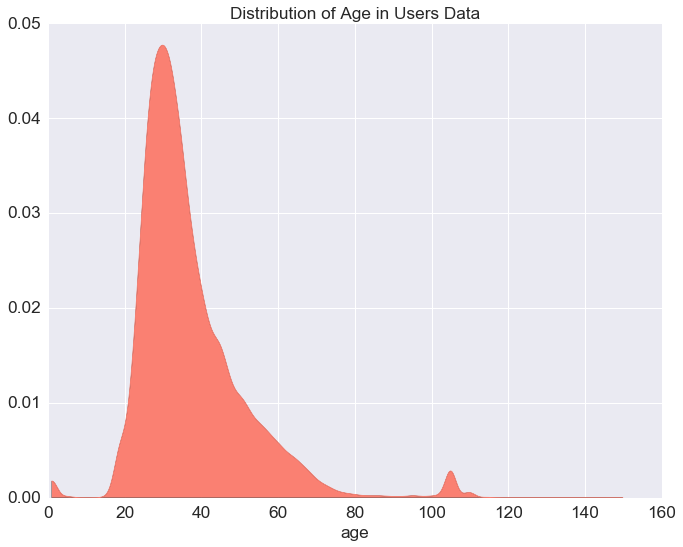

<ggplot: (43276874)>

In [43]:
ggplot.ggplot(
        ggplot.aes(x='age'),
        data=users_df) + \
    ggplot.geom_density(
        color='salmon',
        fill='salmon') + \
    ggplot.ggtitle('Distribution of Age in Users Data') + \
    ggplot.theme_matplotlib(
        rc={# customize MatPlotLib: http://matplotlib.org/users/customizing.html
            'figure.figsize': (11, 8.5),
            'figure.titlesize': 'xx-large',
            'figure.titleweight': 'normal',
            'axes.titlesize': 'xx-large',
            'axes.labelsize': 'xx-large',
            'xtick.labelsize': 'xx-large',
            'ytick.labelsize': 'xx-large'},
        matplotlib_defaults=False)

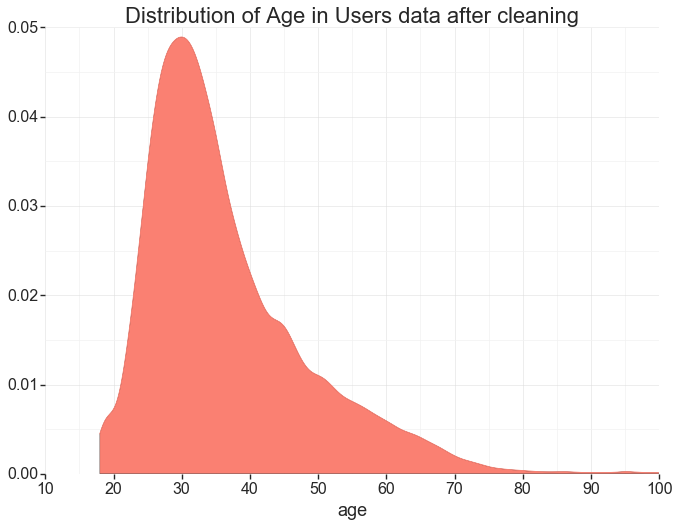

<ggplot: (43276909)>

In [44]:
# let's consequently limit the age range to [18, 100]
min_age_cutoff = 18
max_age_cutoff = 100

users_df.loc[
    (users_df.age < min_age_cutoff) | (users_df.age > max_age_cutoff),
    'age'] = numpy.nan
    
ggplot.ggplot(
        ggplot.aes(x='age'),
        data=users_df) + \
    ggplot.geom_density(
        color='salmon',
        fill='salmon') + \
    ggplot.ggtitle('Distribution of Age in Users data after cleaning') + \
    ggplot.theme_seaborn(
        style='whitegrid',   # whitegrid | darkgrid | nogrid | ticks
        context='poster',      # notebook | talk | paper | poster
        gridweight='light'   # extra heavy | heavy | medium | light
        )

In [45]:
# let's turn our attention to the date-time variables
# let's first rename these columns to make those names shorter
users_df.rename(
    columns=dict(
        date_account_created='acct_crt_date',
        timestamp_first_active='fst_actv_ts',
        date_first_booking='fst_bkg_date'),
    inplace=True)

users_df[
    ['acct_crt_date',
     'fst_actv_ts',
     'fst_bkg_date']]

,acct_crt_date,fst_actv_ts,fst_bkg_date
0,2010-06-28,20090319043255,NaT
1,2011-05-25,20090523174809,NaT
2,2010-09-28,20090609231247,2010-08-02
3,2011-12-05,20091031060129,2012-09-08
4,2010-09-14,20091208061105,2010-02-18
5,2010-01-01,20100101215619,2010-01-02
6,2010-01-02,20100102012558,2010-01-05
7,2010-01-03,20100103191905,2010-01-13
8,2010-01-04,20100104004211,2010-07-29
9,2010-01-04,20100104023758,2010-01-04


In [46]:
# let's extract relevant components such as
# year, month, day, day of week & hour of day
# out of these variables

users_df['acct_crt_yr'] = \
    users_df.acct_crt_date.apply(
        lambda x: x.year)

users_df['acct_crt_mth'] = \
    users_df.acct_crt_date.apply(
        lambda x: x.month)
    
users_df['acct_crt_day'] = \
    users_df.acct_crt_date.apply(
        lambda x: x.day)

users_df['acct_crt_day_of_wk_idx'] = \
    users_df.acct_crt_date.apply(
        lambda x: x.isoweekday())

users_df['acct_crt_day_of_wk'] = \
    users_df.acct_crt_day_of_wk_idx.apply(
        lambda x:
            '%i: %s' % (x, ISO_DAYS_OF_WEEK[x])
            if not numpy.isnan(x)
            else numpy.nan)
    
users_df.fst_actv_ts = \
    users_df.fst_actv_ts.apply(
        lambda x: datetime.datetime(
            year=int(x[:4]),
            month=int(x[4:6]),
            day=int(x[6:8]),
            hour=int(x[8:10]),
            minute=int(x[10:12]),
            second=int(x[12:14])))

users_df['fst_actv_yr'] = \
    users_df.fst_actv_ts.apply(
        lambda x: x.year)

users_df['fst_actv_mth'] = \
    users_df.fst_actv_ts.apply(
        lambda x: x.month)
    
users_df['fst_actv_day'] = \
    users_df.fst_actv_ts.apply(
        lambda x: x.day)

users_df['fst_actv_day_of_wk_idx'] = \
    users_df.fst_actv_ts.apply(
        lambda x: x.isoweekday())

users_df['fst_actv_day_of_wk'] = \
    users_df.fst_actv_day_of_wk_idx.apply(
        lambda x:
            '%i: %s' % (x, ISO_DAYS_OF_WEEK[x])
            if not numpy.isnan(x)
            else numpy.nan)

users_df['fst_actv_hr'] = \
    users_df.fst_actv_ts.apply(
        lambda x: x.hour)

users_df['fst_bkg_yr'] = \
    users_df.fst_bkg_date.apply(
        lambda x: x.year)
    
users_df['fst_bkg_mth'] = \
    users_df.fst_bkg_date.apply(
        lambda x: x.month)
    
users_df['fst_bkg_day'] = \
    users_df.fst_bkg_date.apply(
        lambda x: x.day)

users_df['fst_bkg_day_of_wk_idx'] = \
    users_df.fst_bkg_date.apply(
        lambda x: x.isoweekday())
    
users_df['fst_bkg_day_of_wk'] = \
    users_df.fst_bkg_day_of_wk_idx.apply(
        lambda x:
            '%i: %s' % (x, ISO_DAYS_OF_WEEK[x])
            if not numpy.isnan(x)
            else numpy.nan)

users_df.ix[
    :NB_EXAMPLES_TO_SHOW,
    ['acct_crt_date', 'acct_crt_yr', 'acct_crt_mth', 'acct_crt_day', 'acct_crt_day_of_wk_idx', 'acct_crt_day_of_wk',
     'fst_actv_ts', 'fst_actv_yr', 'fst_actv_mth', 'fst_actv_day', 'fst_actv_day_of_wk_idx', 'fst_actv_day_of_wk', 'fst_actv_hr',
     'fst_bkg_date', 'fst_bkg_yr', 'fst_bkg_mth', 'fst_bkg_day', 'fst_bkg_day_of_wk_idx', 'fst_bkg_day_of_wk']]

,acct_crt_date,acct_crt_yr,acct_crt_mth,acct_crt_day,acct_crt_day_of_wk_idx,acct_crt_day_of_wk,fst_actv_ts,fst_actv_yr,fst_actv_mth,fst_actv_day,fst_actv_day_of_wk_idx,fst_actv_day_of_wk,fst_actv_hr,fst_bkg_date,fst_bkg_yr,fst_bkg_mth,fst_bkg_day,fst_bkg_day_of_wk_idx,fst_bkg_day_of_wk
0,2010-06-28,2010,6,28,1,1: Mon,2009-03-19 04:32:55,2009,3,19,4,4: Thu,4,NaT,NaN,NaN,NaN,NaN,NaN
1,2011-05-25,2011,5,25,3,3: Wed,2009-05-23 17:48:09,2009,5,23,6,6: Sat,17,NaT,NaN,NaN,NaN,NaN,NaN
2,2010-09-28,2010,9,28,2,2: Tue,2009-06-09 23:12:47,2009,6,9,2,2: Tue,23,2010-08-02,2010,8,2,1,1: Mon
3,2011-12-05,2011,12,5,1,1: Mon,2009-10-31 06:01:29,2009,10,31,6,6: Sat,6,2012-09-08,2012,9,8,6,6: Sat
4,2010-09-14,2010,9,14,2,2: Tue,2009-12-08 06:11:05,2009,12,8,2,2: Tue,6,2010-02-18,2010,2,18,4,4: Thu
5,2010-01-01,2010,1,1,5,5: Fri,2010-01-01 21:56:19,2010,1,1,5,5: Fri,21,2010-01-02,2010,1,2,6,6: Sat
6,2010-01-02,2010,1,2,6,6: Sat,2010-01-02 01:25:58,2010,1,2,6,6: Sat,1,2010-01-05,2010,1,5,2,2: Tue
7,2010-01-03,2010,1,3,7,7: Sun,2010-01-03 19:19:05,2010,1,3,7,7: Sun,19,2010-01-13,2010,1,13,3,3: Wed
8,2010-01-04,2010,1,4,1,1: Mon,2010-01-04 00:42:11,2010,1,4,1,1: Mon,0,2010-07-29,2010,7,29,4,4: Thu
9,2010-01-04,2010,1,4,1,1: Mon,2010-01-04 02:37:58,2010,1,4,1,1: Mon,2,2010-01-04,2010,1,4,1,1: Mon


In [49]:
# let's take a look at a summary of the cleaned-up 'users' table
users_df.info(
    verbose=True,
    buf=None,
    max_cols=None,
    memory_usage='deep',
    null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 32 columns):
id                         213451 non-null object
acct_crt_date              213451 non-null datetime64[ns]
fst_actv_ts                213451 non-null datetime64[ns]
fst_bkg_date               88908 non-null datetime64[ns]
gender                     117763 non-null object
age                        122987 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              186185 non-null object
country_destination        213451 non-null object
acct_crt_yr                213451 non-null int64
acct_crt_mth     

### ___`PySpark SQL`___

Highlights:

- __`.distinct()`__: select distinct rows in `PySpark SQL DataFrame`;
<br><br>

- __`DISTINCT`__ term in `SQL` statement;
<br><br>

- Creating and registering new `PySpark SQL DataFrame` that results from `SQL` `SELECT` statement.

In [48]:
print('Distinct values of variables:\n')
for v in cat_vars:
    sqlc.sql(
        "SELECT \
            DISTINCT %s \
        FROM \
            users"
        % v)\
    .show(NB_EXAMPLES_TO_SHOW)

Distinct values of variables:

+---------+
|   gender|
+---------+
|-unknown-|
|   FEMALE|
|     MALE|
|    OTHER|
+---------+

+-------------+
|signup_method|
+-------------+
|     facebook|
|       google|
|        basic|
+-------------+

+-----------+
|signup_flow|
+-----------+
|          0|
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          8|
|         10|
|         12|
|         15|
|         16|
|         20|
|         21|
|         23|
|         24|
|         25|
+-----------+

+--------+
|language|
+--------+
|      fr|
|      sv|
|      zh|
|      th|
|      tr|
|      nl|
|      no|
|      hr|
|      hu|
|      id|
|      ca|
|      is|
|      it|
|      pl|
|      ja|
|      cs|
|      pt|
|      da|
|      de|
|      ko|
|      el|
|      en|
|      es|
|      ru|
|      fi|
+--------+

+-----------------+
|affiliate_channel|
+-----------------+
|          content|
|            other|
|              seo|
|      remarketing|
|   

In [45]:
# This is an alternative method, using Spark's RDD API instead of the SQL DataFrame API
# It is not chosen because the RDD API is much less optimized than the SQL DataFrame APU
# and takes a long time; (plus, collecting results back to the Master / Driver takes long, too)
# for a more concrete understanding, refer to this webinar:
# http://go.databricks.com/apache-spark-1.6-with-patrick-wendell

# for v in ['gender']:
#     print("\nDistinct values of variable '%s':" % v)
#     print(
#         users_ddf\
#         .select(v)\
#         .distinct()\
#         .rdd\
#         .map(lambda row: row[0])\
#         .collect())


Distinct values of variable 'gender':
[u'-unknown-', u'FEMALE', u'MALE', u'OTHER']


In [51]:
# let's clean up by producing a new 'users' table
# through a SQL SELECT statement
# using the various findings above
users_ddf = sqlc.sql(
    "SELECT \
        id, \
        date_account_created AS acct_crt_date, \
        YEAR(date_account_created) AS acct_crt_yr, \
        MONTH(date_account_created) AS acct_crt_mth, \
        DAY(date_account_created) AS acct_crt_day, \
        CAST(DATE_FORMAT(date_account_created, 'u') AS INT) AS acct_crt_day_of_wk_idx, \
        CONCAT(DATE_FORMAT(date_account_created, 'u'), ': ', \
               DATE_FORMAT(date_account_created, 'E')) AS acct_crt_day_of_wk, \
        CAST( \
            CONCAT( \
                SUBSTR(timestamp_first_active, 1, 4), \
                '-', \
                SUBSTR(timestamp_first_active, 5, 2), \
                '-', \
                SUBSTR(timestamp_first_active, 7, 2), \
                ' ', \
                SUBSTR(timestamp_first_active, 9, 2), \
                ':', \
                SUBSTR(timestamp_first_active, 11, 2), \
                ':', \
                SUBSTR(timestamp_first_active, 13, 2)) \
            AS TIMESTAMP) \
            AS fst_actv_ts, \
        date_first_booking AS fst_bkg_date, \
        YEAR(date_first_booking) AS fst_bkg_yr, \
        MONTH(date_first_booking) AS fst_bkg_mth, \
        DAY(date_first_booking) AS fst_bkg_day, \
        CAST(DATE_FORMAT(date_first_booking, 'u') AS INT) AS fst_bkg_day_of_wk_idx, \
        CONCAT(DATE_FORMAT(date_first_booking, 'u'), ': ', \
               DATE_FORMAT(date_first_booking, 'E')) AS fst_bkg_day_of_wk, \
        CASE WHEN age > 1000 THEN 2015 - age \
             ELSE age \
             END \
             AS age, \
        CASE WHEN gender = '-unknown-' THEN NULL \
             ELSE gender \
             END \
             AS gender, \
        language, \
        signup_method, \
        signup_flow, \
        signup_app, \
        first_device_type, \
        CASE WHEN first_browser = '-unknown-' THEN NULL \
             ELSE first_browser \
             END \
             AS first_browser, \
        affiliate_channel, \
        affiliate_provider, \
        CASE WHEN first_affiliate_tracked = 'null' THEN NULL \
             ELSE first_affiliate_tracked \
             END \
             AS first_affiliate_tracked, \
        country_destination \
    FROM \
        users")\
    .cache()
users_ddf.registerTempTable('users')   # this re-registration updates the 'users' table in the SQL Context 

users_ddf = sqlc.sql(
    "SELECT \
        %s, \
        YEAR(fst_actv_ts) AS fst_actv_yr, \
        MONTH(fst_actv_ts) AS fst_actv_mth, \
        DAY(fst_actv_ts) AS fst_actv_day, \
        CAST(FROM_UNIXTIME(CAST(fst_actv_ts AS BIGINT), 'u') AS INT) AS fst_actv_day_of_wk_idx, \
        CONCAT(FROM_UNIXTIME(CAST(fst_actv_ts AS BIGINT), 'u'), ': ', \
               FROM_UNIXTIME(CAST(fst_actv_ts AS BIGINT), 'E')) AS fst_actv_day_of_wk, \
        HOUR(fst_actv_ts) AS fst_actv_hr, \
        CASE WHEN age BETWEEN %i AND %i THEN age \
             ELSE NULL \
             END \
             AS age \
    FROM \
        users"
    % (', '.join(v for v in users_ddf.columns if v != 'age'),
       min_age_cutoff, max_age_cutoff))\
    .cache()
users_ddf.registerTempTable('users')   # this re-registration updates the 'users' table in the SQL Context

print("'users' table (PySpark SQL Distributed DataFrame) schema after cleaning:")
users_ddf.printSchema()

'users' table (PySpark SQL Distributed DataFrame) schema after cleaning:
root
 |-- id: string (nullable = true)
 |-- acct_crt_date: date (nullable = true)
 |-- acct_crt_yr: integer (nullable = true)
 |-- acct_crt_mth: integer (nullable = true)
 |-- acct_crt_day: integer (nullable = true)
 |-- acct_crt_day_of_wk_idx: integer (nullable = true)
 |-- acct_crt_day_of_wk: string (nullable = true)
 |-- fst_actv_ts: timestamp (nullable = true)
 |-- fst_bkg_date: date (nullable = true)
 |-- fst_bkg_yr: integer (nullable = true)
 |-- fst_bkg_mth: integer (nullable = true)
 |-- fst_bkg_day: integer (nullable = true)
 |-- fst_bkg_day_of_wk_idx: integer (nullable = true)
 |-- fst_bkg_day_of_wk: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- language: string (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string

C:\Programs\Anaconda2\lib\site-packages\ggplot\ggplot.py:154: RuntimeWarning: Setting "mpl.rcParams['examples.download']=True" raised an Exception: u'examples.download is not a valid rc parameter.See rcParams.keys() for a list of valid parameters.'
  warnings.warn(msg, RuntimeWarning)
C:\Programs\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


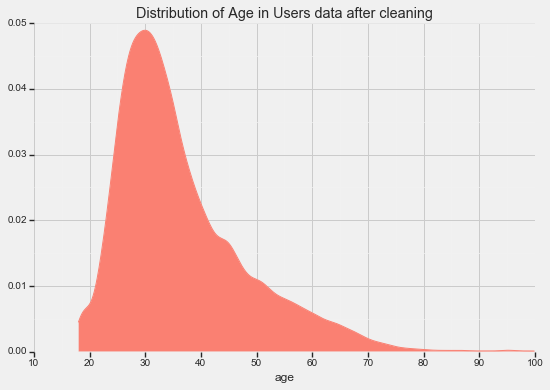

<ggplot: (44567752)>

In [52]:
# let's quickly sanity-check the cleaned-up 'age' variable
ggplot.ggplot(
        ggplot.aes(x='age'),
        data=users_ddf.select('age').toPandas()) + \
    ggplot.geom_density(
        color='salmon',
        fill='salmon') + \
    ggplot.ggtitle('Distribution of Age in Users data after cleaning') + \
    ggplot.theme_538()

In [53]:
users_ddf\
    .select(
        'id',
        'age',
        'gender',
        'language',
        'country_destination')\
    .show(NB_EXAMPLES_TO_SHOW)

+----------+----+------+--------+-------------------+
|        id| age|gender|language|country_destination|
+----------+----+------+--------+-------------------+
|gxn3p5htnn|null|  null|      en|                NDF|
|820tgsjxq7|38.0|  MALE|      en|                NDF|
|4ft3gnwmtx|56.0|FEMALE|      en|                 US|
|bjjt8pjhuk|42.0|FEMALE|      en|              other|
|87mebub9p4|41.0|  null|      en|                 US|
|osr2jwljor|null|  null|      en|                 US|
|lsw9q7uk0j|46.0|FEMALE|      en|                 US|
|0d01nltbrs|47.0|FEMALE|      en|                 US|
|a1vcnhxeij|50.0|FEMALE|      en|                 US|
|6uh8zyj2gn|46.0|  null|      en|                 US|
|yuuqmid2rp|36.0|FEMALE|      en|                 US|
|om1ss59ys8|47.0|FEMALE|      en|                NDF|
|k6np330cm1|null|  null|      en|                 FR|
|dy3rgx56cu|37.0|FEMALE|      en|                NDF|
|ju3h98ch3w|36.0|FEMALE|      en|                NDF|
|v4d5rl22px|33.0|FEMALE|    

In [54]:
users_ddf\
    .select(
        'acct_crt_date',
        'acct_crt_yr',
        'acct_crt_mth',
        'acct_crt_day',
        'acct_crt_day_of_wk_idx',
        'acct_crt_day_of_wk')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+-----------+------------+------------+----------------------+------------------+
|acct_crt_date|acct_crt_yr|acct_crt_mth|acct_crt_day|acct_crt_day_of_wk_idx|acct_crt_day_of_wk|
+-------------+-----------+------------+------------+----------------------+------------------+
|   2010-06-28|       2010|           6|          28|                     1|            1: Mon|
|   2011-05-25|       2011|           5|          25|                     3|            3: Wed|
|   2010-09-28|       2010|           9|          28|                     2|            2: Tue|
|   2011-12-05|       2011|          12|           5|                     1|            1: Mon|
|   2010-09-14|       2010|           9|          14|                     2|            2: Tue|
|   2010-01-01|       2010|           1|           1|                     5|            5: Fri|
|   2010-01-02|       2010|           1|           2|                     6|            6: Sat|
|   2010-01-03|       2010|           1|

In [55]:
users_ddf\
    .select(
        'fst_actv_ts',
        'fst_actv_yr',
        'fst_actv_mth',
        'fst_actv_day',
        'fst_actv_day_of_wk_idx',
        'fst_actv_day_of_wk',
        'fst_actv_hr')\
    .show(NB_EXAMPLES_TO_SHOW)

+--------------------+-----------+------------+------------+----------------------+------------------+-----------+
|         fst_actv_ts|fst_actv_yr|fst_actv_mth|fst_actv_day|fst_actv_day_of_wk_idx|fst_actv_day_of_wk|fst_actv_hr|
+--------------------+-----------+------------+------------+----------------------+------------------+-----------+
|2009-03-19 04:32:...|       2009|           3|          19|                     4|            4: Thu|          4|
|2009-05-23 17:48:...|       2009|           5|          23|                     6|            6: Sat|         17|
|2009-06-09 23:12:...|       2009|           6|           9|                     2|            2: Tue|         23|
|2009-10-31 06:01:...|       2009|          10|          31|                     6|            6: Sat|          6|
|2009-12-08 06:11:...|       2009|          12|           8|                     2|            2: Tue|          6|
|2010-01-01 21:56:...|       2010|           1|           1|                    

In [56]:
users_ddf\
    .select(
        'fst_bkg_date',
        'fst_bkg_yr',
        'fst_bkg_mth',
        'fst_bkg_day',
        'fst_bkg_day_of_wk_idx',
        'fst_bkg_day_of_wk')\
    .show(NB_EXAMPLES_TO_SHOW)

+------------+----------+-----------+-----------+---------------------+-----------------+
|fst_bkg_date|fst_bkg_yr|fst_bkg_mth|fst_bkg_day|fst_bkg_day_of_wk_idx|fst_bkg_day_of_wk|
+------------+----------+-----------+-----------+---------------------+-----------------+
|        null|      null|       null|       null|                 null|             null|
|        null|      null|       null|       null|                 null|             null|
|  2010-08-02|      2010|          8|          2|                    1|           1: Mon|
|  2012-09-08|      2012|          9|          8|                    6|           6: Sat|
|  2010-02-18|      2010|          2|         18|                    4|           4: Thu|
|  2010-01-02|      2010|          1|          2|                    6|           6: Sat|
|  2010-01-05|      2010|          1|          5|                    2|           2: Tue|
|  2010-01-13|      2010|          1|         13|                    3|           3: Wed|
|  2010-07

In [57]:
users_ddf\
    .select(
        'signup_method',
        'signup_app',
        'first_device_type',
        'first_browser',
        'affiliate_channel',
        'affiliate_provider',
        'first_affiliate_tracked')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+----------+-----------------+-------------+-----------------+------------------+-----------------------+
|signup_method|signup_app|first_device_type|first_browser|affiliate_channel|affiliate_provider|first_affiliate_tracked|
+-------------+----------+-----------------+-------------+-----------------+------------------+-----------------------+
|     facebook|       Web|      Mac Desktop|       Chrome|           direct|            direct|              untracked|
|     facebook|       Web|      Mac Desktop|       Chrome|              seo|            google|              untracked|
|        basic|       Web|  Windows Desktop|           IE|           direct|            direct|              untracked|
|     facebook|       Web|      Mac Desktop|      Firefox|           direct|            direct|              untracked|
|        basic|       Web|      Mac Desktop|       Chrome|           direct|            direct|              untracked|
|        basic|       Web|      Mac Desk

## Trend in number of first bookings

In [29]:
print("Non-NULL values for 'country_destination':\n")
hc.sql(
    "SELECT \
        DISTINCT(country_destination) \
    FROM \
        users")\
    .show()

Non-NULL values for 'country_destination':

+-------------------+
|country_destination|
+-------------------+
|                 NL|
|                 AU|
|                 US|
|                 CA|
|                 IT|
|                 PT|
|                NDF|
|              other|
|                 DE|
|                 ES|
|               null|
|                 FR|
|                 GB|
+-------------------+



In [31]:
# clean Users tables
users_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        users"
    % cleaned_user_vars_to_select_str)\
    .cache()
users_ddf.registerTempTable('users')

## Calculate completeness & categorical diversity of each variable in Users data sets

In [32]:
cat_x_vars = \
    ['gender',
     'signup_method',
     'signup_flow', 
     'language',
     'affiliate_channel',
     'affiliate_provider',
     'first_affiliate_tracked',
     'signup_app',
     'first_device_type',
     'first_browser']

users_train_non_null_proportions = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'train'"
        % ', '.join('COUNT(%s) AS %s' % (column, column)
                    for column in users_train_ddf.columns))\
    .toPandas().T.iloc[:, 0] / nb_users_train
users_train_non_null_proportions.name = 'train_non_null'

users_train_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'train'"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_train_nb_cats.name = 'train_nb_cats'

users_test_non_null_proportions = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'test'"
        % ', '.join('COUNT(%s) AS %s' % (column, column)
                    for column in users_test_ddf.columns))\
    .toPandas().T.iloc[:, 0] / nb_users_test
users_test_non_null_proportions.name = 'test_non_null'

users_test_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users \
        WHERE \
            train_valid_test = 'test'"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_test_nb_cats.name = 'test_nb_cats'
    
users_nb_cats = \
    hc.sql(
        "SELECT \
            %s \
        FROM \
            users"
        % ', '.join('COUNT(DISTINCT %s) AS %s' % (column, column)
                    for column in cat_x_vars))\
    .toPandas().T.iloc[:, 0]
users_nb_cats.name = 'overall_nb_cats'

pandas.concat(
    [users_train_non_null_proportions, users_test_non_null_proportions,
     users_train_nb_cats, users_test_nb_cats, users_nb_cats],
    axis=1)

,train_non_null,test_non_null,train_nb_cats,test_nb_cats,overall_nb_cats
affiliate_channel,1.000000,1.000000,8,7,8
affiliate_provider,1.000000,1.000000,18,17,18
age,0.587774,0.534978,NaN,NaN,NaN
country_destination,1.000000,0.000000,NaN,NaN,NaN
date_account_created,1.000000,1.000000,NaN,NaN,NaN
date_first_booking,0.416527,0.000000,NaN,NaN,NaN
first_affiliate_tracked,0.971586,0.999678,7,7,7
first_browser,0.872261,0.724169,51,30,54
first_device_type,1.000000,1.000000,9,9,9
gender,0.551710,0.455810,3,3,3


## Inspect `age` variable in Users data sets

Some quick take-aways and to-dos from the above findings:

- __`date_first_booking`__ is completely missing in the Test set; hence we can exclude it from modeling;

- __`first_browser`__ has way too many categories and is unlikely to be useful; we won't mess around with it either;

- __`signup_flow`__ and __`signup_method`__ have Test-set categories that are not present in the Train set; we'll have to be careful with such cases;

- for __`age`__:
    - there are erroneous values either below the allowed age of 18 or way beyond 100; let's impose cut-offs of 18 and 100 and rule out age values outside this range;  
    - for `NULL` and corrupt age values, let's naïvely impute them with the median of the "legitimate" age values in the Train set; it's probably possible to predict a User's age range from other variables, but let's take this simple approach for now;

- for categorical variables __`first_affiliate_tracked`__ and __`gender`__, let's also naïvely impute `NULL`s with a dummy category named `zzzUNKNOWN`; and

- for date and timestamp variables __`date_account_create`__ and __`timestamp_first_active`__, let's extract out the `year`, `month`, `day`, `day_of_week` and `hour_of_day` components, to be sure of capturing any minute signals contained in them.

In [34]:
min_age_cut_off = 18
max_age_cut_off = 100

median_age_for_imputation = \
    hc.sql(
        "SELECT \
            PERCENTILE_APPROX(age, 0.5) \
        FROM \
            users_train \
        WHERE \
            age BETWEEN %i AND %i"
        % (min_age_cut_off, max_age_cut_off))\
    .rdd.map(lambda row: row[0]).collect()[0]

print('Median Age for Imputation: %.1f years' % median_age_for_imputation)

Median Age for Imputation: 33.0 years


In [35]:
# note that in the below, some supposedly Integer variables are cast as Double
# because Spark ML requires that type for One-Hot Encoding
cleaned_and_imputed_user_vars_to_select_str = \
    "id, \
    date_account_created AS acct_crt_date, \
    YEAR(date_account_created) AS acct_crt_yr, \
    CAST(MONTH(date_account_created) AS DOUBLE) AS acct_crt_mth, \
    CAST(DAY(date_account_created) AS DOUBLE) AS acct_crt_day, \
    CAST(DATE_FORMAT(date_account_created, 'u') AS DOUBLE) AS acct_crt_day_of_wk_idx, \
    CONCAT(DATE_FORMAT(date_account_created, 'u'), ': ', \
           DATE_FORMAT(date_account_created, 'E')) AS acct_crt_day_of_wk, \
    timestamp_first_active AS fst_actv_ts, \
    YEAR(timestamp_first_active) AS fst_actv_yr, \
    CAST(MONTH(timestamp_first_active) AS DOUBLE) AS fst_actv_mth, \
    CAST(DAY(timestamp_first_active) AS DOUBLE) AS fst_actv_day, \
    CAST(FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'u') AS DOUBLE) AS fst_activ_day_of_wk_idx, \
    CONCAT(FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'u'), ': ', \
           FROM_UNIXTIME(CAST(timestamp_first_active AS BIGINT), 'E')) AS fst_actv_day_of_wk, \
    CAST(HOUR(timestamp_first_active) AS DOUBLE) + 1.0 AS fst_actv_hr, \
    CASE WHEN age BETWEEN %i AND %i THEN age \
         ELSE %f \
         END \
         AS age, \
    CASE WHEN gender IS NULL THEN 'zzzUNKNOWN' \
         ELSE gender \
         END \
         AS gender, \
    language, \
    signup_method, \
    signup_flow, \
    signup_app, \
    first_device_type, \
    affiliate_channel, \
    affiliate_provider, \
    CASE WHEN first_affiliate_tracked IS NULL THEN 'zzzUNKNOWN' \
         ELSE first_affiliate_tracked \
         END \
         AS first_affiliate_tracked, \
    country_destination, \
    train_valid_test" \
    % (min_age_cut_off, max_age_cut_off, median_age_for_imputation)

In [36]:
# impute missing values for Users data set
users_imputed_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        users"
    % cleaned_and_imputed_user_vars_to_select_str)\
    .cache()
users_imputed_ddf.registerTempTable('users_imputed')

A quick check on the Users data we have thus far:

In [49]:
help(users_df.rename)

Help on method rename in module pandas.core.frame:

rename(self, index=None, columns=None, **kwargs) method of pandas.core.frame.DataFrame instance
    Alter axes input function or functions. Function / dict values must be
    unique (1-to-1). Labels not contained in a dict / Series will be left
    as-is.
    
    Parameters
    ----------
    index, columns : dict-like or function, optional
        Transformation to apply to that axis values
    
    copy : boolean, default True
        Also copy underlying data
    inplace : boolean, default False
        Whether to return a new DataFrame. If True then value of copy is
        ignored.
    
    Returns
    -------
    renamed : DataFrame (new object)



In [41]:
users_imputed_ddf\
    .select(
        'age',
        'gender',
        'language',
        'signup_method',
        'signup_flow',
        'signup_app',
        'first_device_type')\
    .show(NB_EXAMPLES_TO_SHOW)

+---------+----------+--------+-------------+-----------+----------+-----------------+
|      age|    gender|language|signup_method|signup_flow|signup_app|first_device_type|
+---------+----------+--------+-------------+-----------+----------+-----------------+
|33.029926|zzzUNKNOWN|      EN|     facebook|          0|       Web|      Mac Desktop|
|     38.0|      male|      EN|     facebook|          0|       Web|      Mac Desktop|
|     56.0|    female|      EN|        basic|          3|       Web|  Windows Desktop|
|     42.0|    female|      EN|     facebook|          0|       Web|      Mac Desktop|
|     41.0|zzzUNKNOWN|      EN|        basic|          0|       Web|      Mac Desktop|
|33.029926|zzzUNKNOWN|      EN|        basic|          0|       Web|      Mac Desktop|
|     46.0|    female|      EN|        basic|          0|       Web|      Mac Desktop|
|     47.0|    female|      EN|        basic|          0|       Web|      Mac Desktop|
|     50.0|    female|      EN|        basi

In [43]:
age_gender_year_destination_stats_ddf = hc.sql(
    "SELECT \
        age_bucket, \
        CASE WHEN age_bucket = '100+' THEN 99.5 \
             ELSE CAST(REGEXP_EXTRACT(age_bucket, '([0-9]*)-([0-9]*)', 1) AS DOUBLE) - 0.5 \
             END \
             AS age_from, \
        CASE WHEN age_bucket = '100+' THEN %i + 0.5 \
             ELSE CAST(REGEXP_EXTRACT(age_bucket, '([0-9]*)-([0-9]*)', 2) AS DOUBLE) + 0.5 \
             END \
             AS age_to, \
        gender, \
        country_destination, \
        year, \
        population_in_thousands \
    FROM \
        age_gender_year_destination_stats \
    ORDER BY \
        age_from, \
        gender, \
        country_destination, \
        year"
    % max_age_cut_off)\
    .cache()
age_gender_year_destination_stats_ddf.registerTempTable('age_gender_year_destination_stats')

age_gender_year_destination_stats_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------+--------+------+------+-------------------+------+-----------------------+
|age_bucket|age_from|age_to|gender|country_destination|  year|population_in_thousands|
+----------+--------+------+------+-------------------+------+-----------------------+
|       0-4|    -0.5|   4.5|female|                 AU|2015.0|                  781.0|
|       0-4|    -0.5|   4.5|female|                 CA|2015.0|                  991.0|
|       0-4|    -0.5|   4.5|female|                 DE|2015.0|                 1713.0|
|       0-4|    -0.5|   4.5|female|                 ES|2015.0|                 1198.0|
|       0-4|    -0.5|   4.5|female|                 FR|2015.0|                 1938.0|
|       0-4|    -0.5|   4.5|female|                 GB|2015.0|                 1888.0|
|       0-4|    -0.5|   4.5|female|                 IT|2015.0|                 1383.0|
|       0-4|    -0.5|   4.5|female|                 NL|2015.0|                  438.0|
|       0-4|    -0.5|   4.5|female|        

In [50]:
age_buckets_ddf = hc.sql(
    "SELECT \
        DISTINCT \
            age_bucket, \
            age_from, \
            age_to \
    FROM \
        age_gender_year_destination_stats \
    ORDER BY \
        age_from")\
    .cache()
age_buckets_ddf.registerTempTable('age_buckets')

age_buckets_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------+--------+------+
|age_bucket|age_from|age_to|
+----------+--------+------+
|       0-4|    -0.5|   4.5|
|       5-9|     4.5|   9.5|
|     10-14|     9.5|  14.5|
|     15-19|    14.5|  19.5|
|     20-24|    19.5|  24.5|
|     25-29|    24.5|  29.5|
|     30-34|    29.5|  34.5|
|     35-39|    34.5|  39.5|
|     40-44|    39.5|  44.5|
|     45-49|    44.5|  49.5|
|     50-54|    49.5|  54.5|
|     55-59|    54.5|  59.5|
|     60-64|    59.5|  64.5|
|     65-69|    64.5|  69.5|
|     70-74|    69.5|  74.5|
|     75-79|    74.5|  79.5|
|     80-84|    79.5|  84.5|
|     85-89|    84.5|  89.5|
|     90-94|    89.5|  94.5|
|     95-99|    94.5|  99.5|
|      100+|    99.5| 100.5|
+----------+--------+------+



In [95]:
countries = \
    ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US']
country_attributes = \
    ['lon', 'lat', 'dist', 'area', 'lang', 'lang_dist']
country_features = \
    ['%s_%s' % (ctry, attr) for ctry, attr in itertools.product(countries, country_attributes)]
    
countries_features_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        countries"
    % ', '.join("MAX(CASE WHEN ctry = '%s' THEN %s ELSE NULL END) AS %s"
                % (ctry, attr, '%s_%s' % (ctry, attr))
                for ctry, attr in itertools.product(countries, country_attributes)))\
    .cache()
countries_features_ddf.registerTempTable('countries_features')

countries_features_ddf.printSchema()

root
 |-- AU_lon: double (nullable = true)
 |-- AU_lat: double (nullable = true)
 |-- AU_dist: double (nullable = true)
 |-- AU_area: double (nullable = true)
 |-- AU_lang: string (nullable = true)
 |-- AU_lang_dist: double (nullable = true)
 |-- CA_lon: double (nullable = true)
 |-- CA_lat: double (nullable = true)
 |-- CA_dist: double (nullable = true)
 |-- CA_area: double (nullable = true)
 |-- CA_lang: string (nullable = true)
 |-- CA_lang_dist: double (nullable = true)
 |-- DE_lon: double (nullable = true)
 |-- DE_lat: double (nullable = true)
 |-- DE_dist: double (nullable = true)
 |-- DE_area: double (nullable = true)
 |-- DE_lang: string (nullable = true)
 |-- DE_lang_dist: double (nullable = true)
 |-- ES_lon: double (nullable = true)
 |-- ES_lat: double (nullable = true)
 |-- ES_dist: double (nullable = true)
 |-- ES_area: double (nullable = true)
 |-- ES_lang: string (nullable = true)
 |-- ES_lang_dist: double (nullable = true)
 |-- FR_lon: double (nullable = true)
 |-- FR_l

## Inspect Sessions Data

In [61]:
help(ggplot.theme_matplotlib)

Help on class theme_matplotlib in module ggplot.themes.theme_matplotlib:

class theme_matplotlib(ggplot.themes.theme.theme)
 |  The default matplotlib look and feel.
 |  
 |  The theme can be used (and has the same parameter to customize) like a
 |  matplotlib rc_context() manager.
 |  
 |  Parameters
 |  -----------
 |  rc :  dict of rcParams
 |      rcParams which should be aplied on top of mathplotlib default
 |  fname :  Filename (str)
 |      a filename to a matplotlibrc file
 |  matplotlib_defaults : bool
 |      if True (the default) resets the plot setting to the (current)
 |      matplotlib.rcParams values
 |  
 |  Method resolution order:
 |      theme_matplotlib
 |      ggplot.themes.theme.theme
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, rc=None, fname=None, matplotlib_defaults=True)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from ggplot.themes.theme.theme:
 |  
 |  __add__(self

In [108]:
cat_y_var = 'country_destination'

numerical_x_vars = \
    ['age'] + countries_features_except_lang

indexed_cat_x_vars = \
    ['acct_crt_mth',
     'acct_crt_day',
     'acct_crt_day_of_wk_idx',
     'fst_actv_mth',
     'fst_actv_day',
     'fst_activ_day_of_wk_idx',
     'fst_actv_hr']
    
str_cat_x_vars = \
    ['acct_crt_yr',   # note that we'll treat this Int variable as String
     'fst_actv_yr',   # note that we'll treat this Int variable as String
     'age_bucket',
     'gender',
     'language',
     'signup_method',
     'signup_flow',   # note that we'll treat this Int variable as String
     'signup_app',
     'first_device_type',
     'affiliate_channel',
     'affiliate_provider',
     'first_affiliate_tracked']
    
original_cat_x_vars = indexed_cat_x_vars + str_cat_x_vars
original_x_vars = numerical_x_vars + original_cat_x_vars